In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
from quetzal.io import excel
import numpy as np
import pandas as pd
import geopandas as gpd
from syspy.skims import skims

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [3]:
sm = pathfound = stepmodel.read_zippedpickles(r'../../model/{scen}/modal_split'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 20.32it/s]


## Volume comparison 

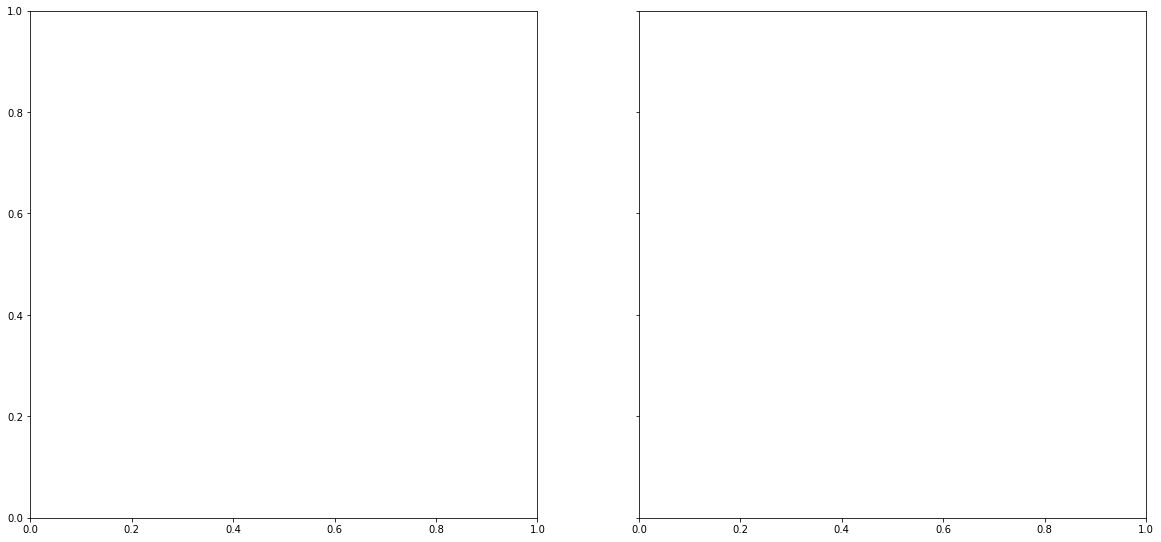

In [4]:
import matplotlib.pyplot as plt
#%matplotlib inline

fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

In [5]:
pathfound.los.groupby('route_types')['volume'].sum()

route_types
(car,)      9219.905443
(pt,)      42583.232264
(walk,)    44441.879966
Name: volume, dtype: float64

In [6]:
pathfound.probabilities.head()

route_type,origin,destination,segment,root,pt,walk,car
0,k2_awee,k1_abdulahi_mussa,todos,1,0.642039,0.118237,0.239724
1,k2_awee,k1_agedalis,todos,1,0.613092,0.112906,0.274002
2,k2_awee,k1_gender_reye,todos,1,0.496296,0.245931,0.257772
3,k2_awee,k1_genede_amerach,todos,1,0.628550,0.135399,0.236052
4,k2_awee,k1_genede_buta,todos,1,0.608118,0.111990,0.279891


In [7]:
s = pathfound.los.groupby('route_types')['volume'].sum()
plot_est = s.plot(
    kind='pie', ax = axes[0], 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[10, 10])
plot_est.set_aspect('equal')

In [8]:
sm = pathfound
trips = pd.read_csv(r'../../../quetzal_dire_dawa/inputs/clean_trips.csv')

trips['departure_time'] = trips['departure_time'].apply(lambda dt_string: pd.Timedelta(dt_string))

trips_hpm=trips.loc[
    (trips['departure_time']>=pd.Timedelta('7 hours'))
    & (trips['departure_time']<=pd.Timedelta('7 hours 55 minutes'))
]

#df_zones = sm.zones[['kebele','latin_name','kebele_latin']].rename(columns={'kebele_latin':'kebele latin'}).reset_index().set_index('latin_name')
#dict_zones = df_zones.to_dict('index')

df_zones = sm.zones[['latin_name', 'kebele']]
dict_zones_ind = df_zones.to_dict('index')
df_zones = df_zones.reset_index()
df_zones['latin_name'] = df_zones['latin_name'].dropna().apply(lambda s : s.replace("_", " "))
df_zones = df_zones.set_index('latin_name').dropna()
dict_zones = df_zones.to_dict('index')

trips_hpm['zone origin']=trips_hpm['zone origin'].apply(lambda s: s.replace("é", "e"))
trips_hpm['zone destination']=trips_hpm['zone destination'].apply(lambda s: s.replace("é", "e"))

trips_hpm['zone origin'] = trips_hpm['zone origin'].apply(lambda i: dict_zones[i]['id'])
trips_hpm['zone destination'] = trips_hpm['zone destination'].apply(lambda i: dict_zones[i]['id'])

trips_modes = trips_hpm.groupby('mode')['weight'].sum().drop(['other', 'staff/school bus'])

r = pd.DataFrame(trips_modes).T
r['pt']=r['bajaj (route)'] + r['minibus']
r['car']=r['car (driver)'] + r['car (passenger)'] + r['moto'] + r['bajaj (contract)']
r['walk']=r['walking']

trips_modes_model = r[['car','pt','walk']].T

plot_real = trips_modes_model['weight'].plot(
    kind='pie', ax = axes[1],
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[10, 10])
plot_real.set_aspect('equal')

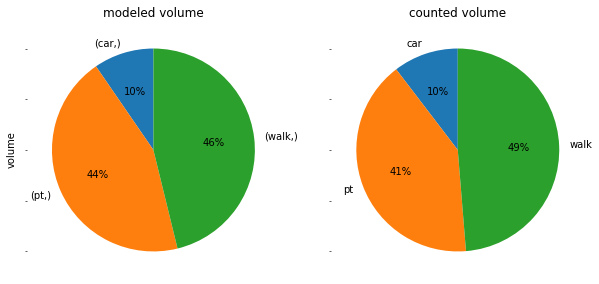

In [9]:
axes[0].set_title('modeled volume')
axes[1].set_title('counted volume')
fig

In [10]:
los = pathfound.los
los.loc[los['route_type']=='walk']
los['tv']=los['volume']*los['time']
los['tv'].sum()/los['volume'].sum()

1664.2331745034346

## Passenger.Km comparison

In [11]:
#Zoning import

zones =  gpd.read_file(r'../../../quetzal_dire_dawa/inputs/zones/zones_name_and_sample.geojson')
zones['kebele_latin'] = zones['kebele_latin'].apply(lambda a: a.replace(" ", "_"))
zones = zones.set_index('kebele_latin')

In [12]:
#Euclidean distance calcule

euclidean = skims.euclidean(zones).set_index(['origin', 'destination'])
intrazonal = 0.8
euclidean['km'] = euclidean['euclidean_distance']/1000 + intrazonal
euclidean.head()

,,euclidean_distance,x_origin,y_origin,x_destination,y_destination,km
origin,destination,,,,,,
k8_mesgid_taliyan,k8_mesgid_taliyan,0.000000,41.871688,9.589288,41.871688,9.589288,0.800000
k8_jemoa_clinic,k8_mesgid_taliyan,245.565953,41.873914,9.589531,41.871688,9.589288,1.045566
k8_sefer_bimea_msbor,k8_mesgid_taliyan,468.376269,41.875943,9.589666,41.871688,9.589288,1.268376
k8_abdi_kulu_garaj,k8_mesgid_taliyan,684.746726,41.877861,9.590223,41.871688,9.589288,1.484747
k8_lege_afe,k8_mesgid_taliyan,886.448563,41.879622,9.590825,41.871688,9.589288,1.686449


In [13]:
#Passenger.Km on estimated volumes

los_pkm = pd.merge(pathfound.los.set_index(['origin', 'destination']),euclidean['km'], left_index=True, right_index=True)
los_pkm['estim_pkm'] = los_pkm['volume']*los_pkm['km']

s_pkm = pd.DataFrame(los_pkm.groupby('route_type')['estim_pkm'].sum())

In [14]:
#Passenger.Km on survey data

real = pd.DataFrame(trips_hpm.groupby(['zone origin', 'zone destination', 'mode'], as_index=False)['weight', 'mode'].sum())
real_pkm = pd.merge(real,euclidean['km'], left_on=(['zone origin', 'zone destination']), right_index=True)

real_pkm['real_pkm'] = real_pkm['weight']*real_pkm['km']

r_pkm = pd.DataFrame(real_pkm.groupby('mode')['real_pkm'].sum()).T
r_pkm['pt']=r_pkm['bajaj (route)'] + r_pkm['minibus']
r_pkm['car']=r_pkm['car (driver)'] + r_pkm['car (passenger)'] + r_pkm['moto'] + r_pkm['bajaj (contract)']
r_pkm['walk']=r_pkm['walking']

r_pkm = r_pkm[['car','pt','walk']].T

Text(0.5, 1.0, 'counted pkm')

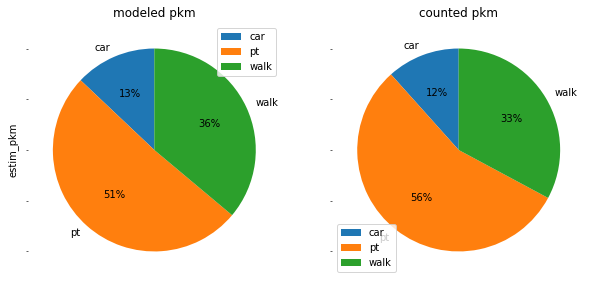

In [15]:
fig_pkm, axes1 = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

axes1[0].set_aspect('equal')
axes1[1].set_aspect('equal')

real_pkm = r_pkm.plot(
    kind='pie', y='real_pkm',
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[10, 10], ax=axes1[1])

estim_plot = s_pkm.plot(
    kind='pie', y='estim_pkm',
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[10, 10], ax=axes1[0])

axes1[0].set_title('modeled pkm')
axes1[1].set_title('counted pkm')

In [16]:
 #plot_pkm = pd.merge(r_pkm,s_pkm, left_index=True, right_index=True).plot(kind = 'bar')

## Export 

In [17]:
fig.savefig(r'../../model/{scen}/calibration/volume_split_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [18]:
fig_pkm.savefig(r'../../model/{scen}/calibration/pkm_split_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [20]:
writer = pd.ExcelWriter(r'../../model/{scen}/calibration/calibration_{scen}.xlsx'.format(scen=scenario), mode='a')
pd.merge(r_pkm,s_pkm, left_index=True, right_index=True).stack().to_excel(writer, sheet_name='modal_split')
writer.save()

FileNotFoundError: [Errno 2] No such file or directory: '../../model/base/calibration/calibration_base.xlsx'

# END

In [ ]:
end_of_notebook